In [1]:
import numpy as np
import tensorflow as tf
import yaml
import matplotlib.pyplot as plt
from multiprocessing import Process, Queue

from mlagents.trainers.ppo.models import PPOModel
from mlagents.trainers.ppo.trainer import PPOTrainer, discount_rewards
from mlagents.trainers.ppo.policy import PPOPolicy
from mlagents.trainers.rl_trainer import AllRewardsOutput
from mlagents.trainers.components.reward_signals import RewardSignalResult
from mlagents.envs.brain import BrainParameters, CameraResolution
from mlagents.envs.environment import UnityEnvironment
from mlagents.envs.mock_communicator import MockCommunicator
from mlagents.trainers.tests import mock_brain as mb
from mlagents.trainers.tests.mock_brain import make_brain_parameters
from mlagents.trainers.custom_layer_specs import CustomConvLayerSpecs

from mlagents.trainers.learn import CommandLineOptions, parse_command_line, create_sampler_manager, try_create_meta_curriculum, prepare_for_docker_run, create_environment_factory

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:

env_name = "../../../../../../ml-agents-master/envs/first_try_conv/Unity Environment"


In [3]:
def dummy_config():
    return yaml.safe_load(
        """
        trainer: ppo
        batch_size: 32
        beta: 5.0e-3
        buffer_size: 512
        epsilon: 0.2
        hidden_units: 128
        lambd: 0.95
        learning_rate: 3.0e-4
        vis_encode_type: custom
        max_steps: 5.0e4
        normalize: true
        num_epoch: 5
        num_layers: 2
        time_horizon: 64
        sequence_length: 64
        summary_freq: 1000
        use_recurrent: false
        memory_size: 8
        curiosity_strength: 0.0
        curiosity_enc_size: 1
        summary_path: test
        model_path: test
        reward_signals:
          extrinsic:
            strength: 1.0
            gamma: 0.99
        """
    )
#         vis_encode_type: custom / simple

In [4]:
# Check if it is the correct folder
import os
environment_dir = "/".join(env_name.split("/")[:-1])
for folder in os.listdir(environment_dir):
    print(folder)


MonoBleedingEdge
Unity Environment.exe
Unity Environment_Data
UnityCrashHandler64.exe
UnityPlayer.dll
WinPixEventRuntime.dll


In [5]:
env = UnityEnvironment(env_name)
brain_infos = env.reset(train_mode=True)

INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Training Brains : 0
        Reset Parameters :
		



In [6]:
default_brain = env.external_brain_names[0]

In [7]:
brain_info = brain_infos[default_brain]

In [8]:
trainer_parameters = dummy_config()

In [9]:
trainer_parameters

{'trainer': 'ppo',
 'batch_size': 32,
 'beta': 0.005,
 'buffer_size': 512,
 'epsilon': 0.2,
 'hidden_units': 128,
 'lambd': 0.95,
 'learning_rate': 0.0003,
 'vis_encode_type': 'custom',
 'max_steps': '5.0e4',
 'normalize': True,
 'num_epoch': 5,
 'num_layers': 2,
 'time_horizon': 64,
 'sequence_length': 64,
 'summary_freq': 1000,
 'use_recurrent': False,
 'memory_size': 8,
 'curiosity_strength': 0.0,
 'curiosity_enc_size': 1,
 'summary_path': 'test',
 'model_path': 'test',
 'reward_signals': {'extrinsic': {'strength': 1.0, 'gamma': 0.99}}}

In [10]:
trainer_parameters["layers_specs"] = [
    {
        "type": "conv2D",
        "filters": 32,
        "activation": "relu",
        "use_bias": True,
        "maxPool": False,
        "kernel_shape": (8,8),
        "strides": (4,4),
        "kernel_initializer": "glorot_uniform",
        "bias_initializer": "zeros",
    },
    {
        "type": "conv2D",
        "filters": 32,
        "activation": "relu",
        "use_bias": True,
        "maxPool": False,
        "kernel_shape": (4,4),
        "strides": (2,2),
        "kernel_initializer": "glorot_uniform",
        "bias_initializer": "zeros",
    }
]

In [11]:
temp = trainer_parameters["layers_specs"][0].copy()

In [12]:
del temp["type"]

In [13]:
out = CustomConvLayerSpecs(**temp)

In [14]:
out.__dict__

{'filters': 32,
 'kernel_shape': (8, 8),
 'strides': (4, 4),
 'activation': 'relu',
 'kernel_initializer': 'glorot_uniform',
 'bias_initializer': 'zeros',
 'use_bias': True,
 'maxPool': False}

In [15]:
env.external_brain_names

['RollerBallVisualBrain']

In [16]:
camera_resolution = CameraResolution(84,84,3)
brain_params = BrainParameters(
    "test_brain",        # brain_name
    0,                   # vector_observation_space_size
    0,                   # num_stacked_vector_observations
    [camera_resolution], # camera_resolutions
    [4],                 # vector_action_space_size
    [],                  # vector_action_descriptions
    1                    # vector_action_space_type
)
trainer = PPOTrainer(brain_params, 0, trainer_parameters, True, False, 0, "0", False)
policy = trainer.policy
model = policy.model
# policy = PPOPolicy(0, env.brains[env.external_brain_names[0]], trainer_parameters, False, False)


--check



Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Use keras.layers.Dense instead.


--check



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:

brain_info = brain_infos[default_brain]
print(brain_info)

Agent observations look like:


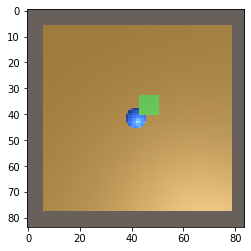

In [18]:

# Examine the observation space for the default brain
for observation in brain_info.visual_observations:
    print("Agent observations look like:")
    observation = np.array(observation)
    if observation.shape[3] == 3:
        plt.imshow(observation[0,:,:,:])
    else:
        plt.imshow(observation[0,:,:,0])

In [19]:
# trainer.policy.evaluate(brain_info)

In [20]:
run_out = policy.get_value_estimates(brain_info, 0, done=False)

In [21]:
run_out = policy.evaluate(brain_info)

In [22]:
brain_info.visual_observations[0][0].shape

(84, 84, 3)

In [23]:
run_out

{'action': array([[ 0.4699039 , -0.0422685 , -0.28713787,  0.24907106]],
       dtype=float32),
 'log_probs': array([[-1.904729 , -0.9266766, -1.288302 , -1.1981091]], dtype=float32),
 'value_heads': {'extrinsic': array([[-0.0326346]], dtype=float32)},
 'value': array([[-0.0326346]], dtype=float32),
 'entropy': array([1.4189385], dtype=float32),
 'learning_rate': 0.0003,
 'pre_action': array([[ 1.4097116, -0.1268055, -0.8614136,  0.7472132]], dtype=float32),
 'random_normal_epsilon': array([[ 1.40413   , -0.12440282, -0.85949221,  0.74722242]])}

In [24]:
for key, val in run_out.items():
    print(key, ":", val)

action : [[ 0.4699039  -0.0422685  -0.28713787  0.24907106]]
log_probs : [[-1.904729  -0.9266766 -1.288302  -1.1981091]]
value_heads : {'extrinsic': array([[-0.0326346]], dtype=float32)}
value : [[-0.0326346]]
entropy : [1.4189385]
learning_rate : 0.0003
pre_action : [[ 1.4097116 -0.1268055 -0.8614136  0.7472132]]
random_normal_epsilon : [[ 1.40413    -0.12440282 -0.85949221  0.74722242]]


In [25]:
model.output

<tf.Tensor 'action:0' shape=(?, 4) dtype=float32>

In [26]:
model.vector_in

<tf.Tensor 'vector_observation:0' shape=(?, 0) dtype=float32>

In [27]:
model.visual_in[0]

<tf.Tensor 'visual_observation_0:0' shape=(?, 84, 84, 3) dtype=float32>

In [28]:
model.output_pre

<tf.Tensor 'add_6:0' shape=(?, 4) dtype=float32>

In [29]:
# feed_dict = {
#     policy.model.batch_size: 1,
#     policy.model.sequence_length: 1,
# }
# for i in range(len(brain_info.visual_observations)):
#     feed_dict[policy.model.visual_in[i]] = [
#         brain_info.visual_observations[i][0]
#     ]

In [30]:
env.close()

INFO:mlagents.envs:Environment shut down with return code 0 (CTRL_C_EVENT).


In [31]:

trainer_config = dummy_config()
trainer_config["layers_specs"] = [
    {
        "type": "conv2D",
        "filters": 32,
        "activation": "relu",
        "use_bias": True,
        "maxPool": False,
        "kernel_shape": (8,8),
        "strides": (4,4),
        "kernel_initializer": "glorot_uniform",
        "bias_initializer": "zeros",
    },
    {
        "type": "conv2D",
        "filters": 32,
        "activation": "relu",
        "use_bias": True,
        "maxPool": False,
        "kernel_shape": (4,4),
        "strides": (2,2),
        "kernel_initializer": "glorot_uniform",
        "bias_initializer": "zeros",
    }
]
trainer_config = {
    "default": trainer_config
}

In [32]:
defaultCommandLineOptionsDict = {
    "debug":False,
    "num_runs": 1,
    "seed": -1,
    "env_path": env_name,
    "run_id": "ppo_test",
    "load_model": False,
    "train_model": True,
    "save_freq": 50000,
    "keep_checkpoints": 5,
    "base_port": 5005,
    "num_envs": 1,
    "curriculum_folder": None,
    "lesson": 0,
    "slow": False,
    "no_graphics": False,
    "multi_gpu": False,  
    "trainer_config_path": "boeit niet meer",
    "sampler_file_path": None,
    "docker_target_name": None,
    "env_args": None,
    "cpu": False,
}
defaultCommandLineOptions = CommandLineOptions(**defaultCommandLineOptionsDict)

In [33]:
# # Unity ML-Agents Toolkit
import logging
import argparse

from multiprocessing import Process, Queue
import os
import glob
import shutil
import numpy as np

from typing import Any, Callable, Optional, List, NamedTuple


from mlagents.trainers.trainer_controller import TrainerController
from mlagents.trainers.exception import TrainerError
from mlagents.trainers.meta_curriculum import MetaCurriculum
from mlagents.trainers.trainer_util import load_config, TrainerFactory
from mlagents.envs.environment import UnityEnvironment
from mlagents.envs.sampler_class import SamplerManager
from mlagents.envs.exception import SamplerException
from mlagents.envs.base_unity_environment import BaseUnityEnvironment
from mlagents.envs.subprocess_env_manager import SubprocessEnvManager


In [34]:
def run_training(sub_id: int, run_seed: int, options: CommandLineOptions, process_queue: Queue, trainer_config):
    curriculum_folder = options.curriculum_folder
    # Recognize and use docker volume if one is passed as an argument
    if not options.docker_target_name:
        model_path = "./models/{run_id}-{sub_id}".format(
            run_id=options.run_id, sub_id=sub_id
        )
        summaries_dir = "./summaries"
    else:
        if curriculum_folder is not None:
            curriculum_folder = "/{docker_target_name}/{curriculum_folder}".format(
                docker_target_name=options.docker_target_name,
                curriculum_folder=curriculum_folder,
            )
        model_path = "/{docker_target_name}/models/{run_id}-{sub_id}".format(
            docker_target_name=options.docker_target_name,
            run_id=options.run_id,
            sub_id=sub_id,
        )
        summaries_dir = "/{docker_target_name}/summaries".format(
            docker_target_name=options.docker_target_name
        )
    port = options.base_port + (sub_id * options.num_envs)
    if options.env_path is None:
        port = 5004  # This is the in Editor Training Port
    env_factory = create_environment_factory(
        options.env_path,
        options.docker_target_name,
        options.no_graphics,
        run_seed,
        port,
        options.env_args,
    )
    env = SubprocessEnvManager(env_factory, options.num_envs)
    maybe_meta_curriculum = try_create_meta_curriculum(
        curriculum_folder, env, options.lesson
    )
    sampler_manager, resampling_interval = create_sampler_manager(
        options.sampler_file_path, env.reset_parameters, run_seed
    )
    trainer_factory = TrainerFactory(
        trainer_config,
        summaries_dir,
        options.run_id,
        model_path,
        options.keep_checkpoints,
        options.train_model,
        options.load_model,
        run_seed,
        maybe_meta_curriculum,
        options.multi_gpu,
    )
    # Create controller and begin training.
    tc = TrainerController(
        trainer_factory,
        model_path,
        summaries_dir,
        options.run_id + "-" + str(sub_id),
        options.save_freq,
        maybe_meta_curriculum,
        options.train_model,
        run_seed,
        options.fast_simulation,
        sampler_manager,
        resampling_interval,
    )
    # Signal that environment has been launched.
    process_queue.put(True)
    # Begin training
    tc.start_learning(env)

In [35]:

run_seed = np.random.randint(0, 10000)
run_training(0, run_seed, defaultCommandLineOptions, Queue(), trainer_config)

--check
Instructions for updating:
Use `tf.random.categorical` instead.


Instructions for updating:
Use `tf.random.categorical` instead.
INFO:mlagents.envs:Hyperparameters for the PPOTrainer of brain RollerBallVisualBrain: 
	trainer:	ppo
	batch_size:	32
	beta:	0.005
	buffer_size:	512
	epsilon:	0.2
	hidden_units:	128
	lambd:	0.95
	learning_rate:	0.0003
	vis_encode_type:	custom
	max_steps:	5.0e4
	normalize:	True
	num_epoch:	5
	num_layers:	2
	time_horizon:	64
	sequence_length:	64
	summary_freq:	1000
	use_recurrent:	False
	memory_size:	8
	curiosity_strength:	0.0
	curiosity_enc_size:	1
	summary_path:	./summaries/ppo_test_RollerBallVisualBrain
	model_path:	./models/ppo_test-0/RollerBallVisualBrain
	reward_signals:	
	  extrinsic:	
	    strength:	1.0
	    gamma:	0.99
	layers_specs:	[{'type': 'conv2D', 'filters': 32, 'activation': 'relu', 'use_bias': True, 'maxPool': False, 'kernel_shape': (8, 8), 'strides': (4, 4), 'kernel_initializer': 'glorot_uniform', 'bias_initializer': 'zeros'}, {'type': 'conv2D', 'filters': 32, 'activation': 'relu', 'use_bias': True, 'maxPool


INFO:mlagents.trainers: ppo_test: RollerBallVisualBrain: Step: 1000. Time Elapsed: 9.948 s Mean Reward: -0.600. Std of Reward: 0.800. Training.



INFO:mlagents.trainers: ppo_test: RollerBallVisualBrain: Step: 2000. Time Elapsed: 19.046 s Mean Reward: -0.660. Std of Reward: 0.751. Training.
INFO:mlagents.trainers: ppo_test: RollerBallVisualBrain: Step: 3000. Time Elapsed: 27.580 s Mean Reward: -0.774. Std of Reward: 0.634. Training.
INFO:mlagents.trainers: ppo_test: RollerBallVisualBrain: Step: 4000. Time Elapsed: 36.074 s Mean Reward: -0.804. Std of Reward: 0.595. Training.
INFO:mlagents.trainers: ppo_test: RollerBallVisualBrain: Step: 5000. Time Elapsed: 44.493 s Mean Reward: -0.614. Std of Reward: 0.789. Training.
INFO:mlagents.trainers: ppo_test: RollerBallVisualBrain: Step: 6000. Time Elapsed: 52.276 s Mean Reward: -0.538. Std of Reward: 0.843. Training.
INFO:mlagents.trainers: ppo_test: RollerBallVisualBrain: Step: 7000. Time Elapsed: 60.727 s Mean Reward: -0.640. Std of Reward: 0.768. Training.
INFO:mlagents.trainers: ppo_test: RollerBallVisualBrain: Step: 8000. Time Elapsed: 69.097 s Mean Reward: -0.542. Std of Reward: 0


INFO:mlagents.envs:Saved Model
INFO:mlagents.trainers: ppo_test: RollerBallVisualBrain: Step: 50000. Time Elapsed: 420.366 s Mean Reward: -0.133. Std of Reward: 0.991. Training.
INFO:mlagents.envs:Saved Model
INFO:mlagents.trainers:List of nodes to export for brain :RollerBallVisualBrain
INFO:mlagents.trainers:	is_continuous_control
INFO:mlagents.trainers:	version_number
INFO:mlagents.trainers:	memory_size
INFO:mlagents.trainers:	action_output_shape
INFO:mlagents.trainers:	action


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


INFO:tensorflow:Froze 13 variables.


INFO:tensorflow:Froze 13 variables.


INFO:tensorflow:Converted 13 variables to const ops.


INFO:tensorflow:Converted 13 variables to const ops.


Converting ./models/ppo_test-0/RollerBallVisualBrain/frozen_graph_def.pb to ./models/ppo_test-0/RollerBallVisualBrain.nn




INFO:mlagents.trainers:Exported ./models/ppo_test-0/RollerBallVisualBrain.nn file


GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'main_graph_0_encoder0/conv_0/BiasAdd'
IN: 'action_masks': [-1, 1, 1, 4] => 'strided_slice_1'
OUT: 'concat/concat', 'action_probs/action_probs', 'concat_3/concat', 'action'
DONE: wrote ./models/ppo_test-0/RollerBallVisualBrain.nn file.


In [36]:
trainer_config

{'default': {'trainer': 'ppo',
  'batch_size': 32,
  'beta': 0.005,
  'buffer_size': 512,
  'epsilon': 0.2,
  'hidden_units': 128,
  'lambd': 0.95,
  'learning_rate': 0.0003,
  'vis_encode_type': 'custom',
  'max_steps': '5.0e4',
  'normalize': True,
  'num_epoch': 5,
  'num_layers': 2,
  'time_horizon': 64,
  'sequence_length': 64,
  'summary_freq': 1000,
  'use_recurrent': False,
  'memory_size': 8,
  'curiosity_strength': 0.0,
  'curiosity_enc_size': 1,
  'summary_path': 'test',
  'model_path': 'test',
  'reward_signals': {'extrinsic': {'strength': 1.0, 'gamma': 0.99}},
  'layers_specs': [{'type': 'conv2D',
    'filters': 32,
    'activation': 'relu',
    'use_bias': True,
    'maxPool': False,
    'kernel_shape': (8, 8),
    'strides': (4, 4),
    'kernel_initializer': 'glorot_uniform',
    'bias_initializer': 'zeros'},
   {'type': 'conv2D',
    'filters': 32,
    'activation': 'relu',
    'use_bias': True,
    'maxPool': False,
    'kernel_shape': (4, 4),
    'strides': (2, 2),
  